# Les modèles d'Arbre de Décision
---

Les arbres de décision sont des algorithmes de machine learning pouvant être utilisés pour : 
- **Un problème de régression** où la variable à prédire est quantitative (pour prédire par exemple le prix d'une maison)
- **Un problème de classification** où la variable à prédire est qualitative (prédire le spam d'un e-mail)

## 1 – Arbre de Decision : Classifieur

Le modèle d'arbre classifieur est un arbre binaire où les prédictions sont faites en parcourant l'arbre de **la racine** à **la feuille**.

Lors du parcours de chaque noeud :

- si une **caractéristique est inférieure à un seuil**, nous allons à gauche, à droite sinon.
- chaque **feuille est associée à une classe**, qui est la prédiction du modèle.

> On utilisera le jeu de données *iris* pour implémenter le classifieur

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()

X = iris.data
y = iris.target

In [3]:
X = pd.DataFrame(X, columns=iris.feature_names)
y = pd.Series(y, name="y")

### 1.1 Métrique de split 

#### A. L'indice de GINI

Les arbres de décision utilisent le concept **d'impureté de Gini** pour décrire à quel point un noeud est *homogène* ou *pur*. 

Un noeud est dit pur $(G = 0)$ si toutes ses observations appartiennent à la même classe, tandis qu'un noeud avec de nombreuses observations de classes différentes aura un Gini proche de 1.

On défini **l'impureté Gini** de $n$ échantillons répartis en $k$ classes par :

$$\text{G} = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}}{s} \right)^2}$$

où : 
- $s$ correspond à l'échantillon total
- $s_k$ correspond à la part de l'échantillon appartenant à la classe $k$

>On peut par exemple calculer l'indice de Gini sur des données du Dataset *iris*, pour le premier noeud parent

In [4]:
def _gini(y):
    m = y.size
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

In [5]:
_gini(y)

0.6666666666666667

#### B. l'Entropie de Shanon

**l'Entropie** est une métrique qui mesure le désordre dans un systeme.

...


...

### 1.2. L'algorithme CART

L'algorithme utilisé dans un arbre de décision de type classifieur est appelée CART (abréviation de *Classification And Régression Trees*). Cette algorithme consiste de partir de la racine de trouver le meilleur split (chaque noeud est construit de manière à minimiser l'impureré de Gini de chaque enfant) successivement.

La récursivité s'arrête lorsque la profondeur maximale est atteinte, c'est à dire quand plus aucune séparation n'est possible de manière plus pur que le noeud parent. 

*NB : Il est possible de contrôler le critère d'arrêt qui est crucial en pratique car il permet d'éviter le surapprentissage.*

### 1.3. Recherche des noeuds fils : la variable et le seuil optimal 

L'objectif de l'algorithme CART est de trouver la variable et le seuil optimal pour que l'impureté de Gini soit minimisée. On parle de la *racine* dans le cas du premier noeud de l'arbre.

Pour ce faire : **il faut calculer l'indice de Gini pour toutes les divisions possibles**. 

- Pour le cas d'une variable expliquée **binaire**, il faut juster compter le nombre de modalité pour le split de cette variable.

- Pour une valeur **continue**, il faut au préalable trier les valeurs et utiliser comme seuil tous les points médians entre deux valeurs adjacentes.

#### A. Recherches des valeurs seuils

> **Pour trouver tous les ponts médian** : On considère une variable du jeu de données et on récupère toutes les valeurs possibles

In [42]:
t = X["petal length (cm)"].unique()
t

array([1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1. , 1.9, 4.7, 4.5, 4.9, 4. ,
       4.6, 3.3, 3.9, 3.5, 4.2, 3.6, 4.4, 4.1, 4.8, 4.3, 5. , 3.8, 3.7,
       5.1, 3. , 6. , 5.9, 5.6, 5.8, 6.6, 6.3, 6.1, 5.3, 5.5, 6.7, 6.9,
       5.7, 6.4, 5.4, 5.2])

> Ne pas oublier de trier la liste

In [11]:
def __make_threshold(liste):
    liste_sorted = sorted(liste)
    return np.array([np.mean((liste_sorted[i], liste_sorted[i+1])) 
            for i in range(len(liste_sorted))[:-1]])

> On applique la moyenne pour chaque observation deux à deux (sans oublier de retirer la dernière valeur pour éviter de retourner une erreur)

In [10]:
__make_threshold(t)

array([1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.8 , 2.45, 3.15, 3.4 ,
       3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55,
       4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65,
       5.75, 5.85, 5.95, 6.05, 6.2 , 6.35, 6.5 , 6.65, 6.8 ])

#### B. Gini pondéré

Après avoir trouver l'ensemble des seuils possibles pour une variable quanti (c'est aussi le cas pour une variable quali, mais l'arbre gère cela de manière ordinale) il faut maintenant selectionner le meilleur seuil qui minimise **l'indice de Gini pondéré** (entre les deux Gini de chaque embranchement). 

1 - Dans une première étape, il faut calculer l'indice de Gini pour le **noeud fils de gauche et de droite** (il faut obligatoirement une séparation en deux modalités).

Pour le noeud de gauche : 

- $i$ : désigne le nombre d'observations répondant vraie au seuil de la variable
- $s_k^{i}$ : désigne le nombre d'observation répondant au seuil de la variable choisit et à la modalité $k$

$$G^{left}_i = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}^{i}}{i} \right)^2}$$

De manière symétrique pour le noeud de droite : 

$$G^{right}_i = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}^{i-}}{i-} \right)^2}$$

*Note : $i-$ correspond à l'inverse du seuil, donc les modalités fausses* 

2 - Dans une deuxième étape il faut maintenant calculer **le gini pondéré** entre les deux noeuds fils pour connaitre le gini de cet embranchement.

$$G_n =  \frac{i}{s} \; G^{left}_i + \frac{i-}{s} \; G^{right}_i $$

> On prend une des variable du jeu de données iris et on calcule l'indice de Gini fils optimal pour chacun des seuils possibles. On peut fixer un seuil arbitraire pour commencer.

In [25]:
def node_child(X,y,var,threshold):
    classe = X[var] < threshold
    
    m = len(y)
    number_left = sum(classe)
    number_right = sum(~classe)
    
    gini_left = 1.0 - sum((sum(classe[y == i]) / number_left) ** 2 
                      for i in np.unique(y))
    gini_right = 1.0 - sum((sum(~classe[y == i]) / number_right) ** 2 
                       for i in np.unique(y))
    
    gini_pondere = (number_left * gini_left + number_right * gini_right) / m
    return gini_pondere

> Pour la variable *petal length (cm)* on applique le seuil de 4 (toujours inférieur).

In [27]:
node_child(X,y, "petal length (cm)",4)

0.41235341069564685

On peut maintenant répeter cela pour tous les splits possibles de cette variable : 

In [37]:
liste_gini_pondere = []

for i in __make_threshold(np.unique(X["petal length (cm)"])):
    gini_pondere = node_child(X,y,'petal length (cm)',i)
    liste_gini_pondere.append((gini_pondere,i))

Il est possible d'afficher l'ensemble des Gini pondérés afin de retenir le meilleur seuil de séparation **pour cette variable**.

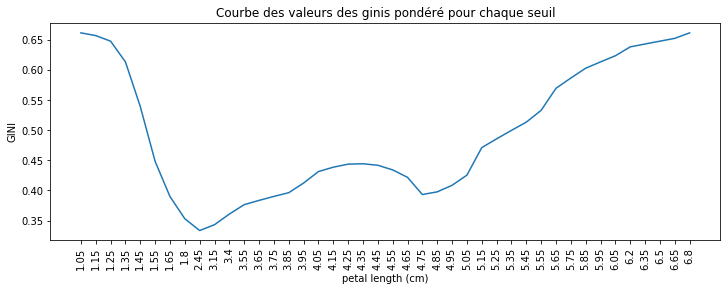

In [41]:
plt.figure(figsize=(12,4))
plt.plot([i[0] for i in liste_gini_pondere])
plt.xticks(ticks=range(len(liste_gini_pondere)),
           labels=[np.round(i[1],2) for i in liste_gini_pondere], 
           rotation='vertical')
plt.xlabel(iris.feature_names[2])
plt.ylabel('GINI');
plt.title('Courbe des valeurs des ginis pondéré pour chaque seuil');

On peut donc voir que le seuil optimal de séparation est : $2.45$. L'indice de Gini associé est inférieur à 0,35. Cependant, il s'agit du meilleur seuil pour cette variable. Il faut donc itérer pour chacune des variables et chercher le meilleur split parmi l'ensemble des variables possibles.

3 - La troisième étape consiste donc de retenir l'échantillon respectant le split du noeud et appliquer la même méthode pour chaque embranchement de manière successive. La classification consiste à retenir la classe majoritaire au sein d'un noeud.

> La fonction suivante reprend toutes les étapes précédentes et cherche le split optimal pour l'ensemble des variables

In [65]:
def _best_gini(X,y, target_name=None):
    """
    Permet de trouver le meilleur split à partir de l'indice de Gini pondéré
    """

    # Calcule la pureté du noeud (l'indice de GINI parent) et 
    # retourne la classe majoritaire
    gini_node = _gini(y)
    classe_maj = y.mode()[0]
    
    
    if target_name is not None:
        classe_maj = target_name[classe_maj]
    else :
        target_name = {i : i for i in np.unique(y)}



    all_split = []

    # Cherche pour chaque variable le meilleur split 

    for var in X.columns:

        # Calcule les valeurs intermédiaires de toutes les valeurs possibles de la variable
        # Pour éviter la division par 0 si un split ne contient aucune valeur.

        res = []
        all_treshold = __make_threshold(np.unique(X[var]))

        for threshold in all_treshold:

            # Récupère les données pour le split selon le threshold
            classe = X[var] < threshold

            # Effectifs pour chaque classe et le total
            m = len(y)
            number_left = sum(classe)
            number_right = sum(~classe)

            # Indice de gini pour la branche de gauche et de droite
            gini_left = 1.0 - sum((sum(classe[y == i]) / number_left) ** 2 
                                  for i in np.unique(y))
            gini_right = 1.0 - sum((sum(~classe[y == i]) / number_right) ** 2 
                                   for i in np.unique(y))

            # Répartition de l'échantillon pour le split
            sample_left_count = {target_name[i] : sum(classe[y == i]) for i in np.unique(y)}
            sample_right_count = {target_name[i] : sum(~classe[y == i]) for i in np.unique(y)}
            
            sample_left = {target_name[i] : classe[y == i] for i in np.unique(y)}
            sample_right = {target_name[i] : ~classe[y == i] for i in np.unique(y)}

            # Gini pondéré entre les deux splits
            gini_pondere = (number_left * gini_left + number_right * gini_right) / m

            # Ajoute l'ensemble des résultats dans une liste
            res.append((gini_pondere, threshold, sample_left_count, 
                        sample_right_count, sample_left, sample_right))

        # Créer un DataFrame de l'ensemble des résultats pour chaque split
        best_gini = pd.DataFrame(res, columns=["gini","value",'sample_left', 'sample_right','data_left','data_right'])

        # Selectionne la ligne de l'indice de gini pondéré le plus faible et son seuil
        argmin = best_gini.gini.idxmin()
        threshold = best_gini.loc[argmin].value

        # Ajoute le meilleur split (indice de gini pondéré) pour chaque variable
        all_split.append((best_gini.gini.min(), threshold, var, 
                          best_gini.sample_left[argmin], best_gini.sample_right[argmin],
                        gini_node, classe_maj))

    # Transforme sous forme de DataFrame et trie par ordre ascendant
    node = pd.DataFrame(all_split, columns=["Gini pondéré", "threshold (<=) ", 
                                'feature', 'sample_left', 
                                "sample_right", 'gini_node',"classe"]
                               ).sort_values(by=["Gini pondéré"], ascending=True).reset_index(drop=True)
    return node.loc[0], best_gini.data_left[argmin], best_gini.data_right[argmin]

In [88]:
node, sample_left, sample_right = _best_gini(X,y, iris.target_names)

On peut récuperer les informations du meilleurs split pour la meileure variable : 

In [89]:
node

Gini pondéré                                               0.333333
threshold (<=)                                                 2.45
feature                                           petal length (cm)
sample_left         {'setosa': 50, 'versicolor': 0, 'virginica': 0}
sample_right       {'setosa': 0, 'versicolor': 50, 'virginica': 50}
gini_node                                                  0.666667
classe                                                       setosa
Name: 0, dtype: object

In [87]:
for i in sample_right.values():
    print(i)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
Name: petal width (cm), dtype: bool
50    True
51    True
52    True
53    True
54    True
55    True
56    True
57    True
58    True
59    True
60    True
61    True
62    True
63    True
64    True
65    True
66    True
67    True
68    True
69    True
70    True
71    True
72    True
73    True
74    True
75    True
76    True
77    True
78    True
79    True
80    True
81    True
82    True
8

In [13]:
class DecisionTreeClassif():
    def __init__(self, max_depth=None, target_name=None):
        self.max_depth = max_depth
        self.target_name = target_name
    
    def _gini(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 
                         for c in np.unique(y))
    
    def __make_threshold(self, liste):
        liste_sorted = sorted(liste)
        return np.array([np.mean((liste_sorted[i], liste_sorted[i+1])) 
                for i in range(len(liste_sorted))[:-1]])

    def fit(self,X,y):
        self.all_classes = np.unique(y)
        self.tree = self._best_gini(X,y, target_name=self.target_name)
        return self.tree
        
    def _best_gini(self, X,y, target_name):
        """
        Permet de trouver le meilleur split à partir de l'indice de Gini pondéré
        """

        # Calcule la pureté du noeud (l'indice de GINI parent) et 
        # retourne la classe majoritaire
        gini_node = self._gini(y)
        classe_maj = y.mode()[0]

        if target_name is not None:
            classe_maj = target_name[classe_maj]

        all_split = []

        # Cherche pour chaque variable le meilleur split 

        for var in X.columns:

            # Calcule les valeurs intermédiaires de toutes les valeurs possibles de la variable
            # Pour éviter la division par 0 si un split ne contient aucune valeur.

            res = []
            all_treshold = self.__make_threshold(np.unique(X[var]))

            for threshold in all_treshold:

                # Récupère les données pour le split selon le threshold
                classe = X[var] < threshold

                # Effectifs pour chaque classe et le total
                m = len(y)
                number_left = sum(classe)
                number_right = sum(~classe)

                # Indice de gini pour la branche de gauche et de droite
                gini_left = 1.0 - sum((sum(classe[y == i]) / number_left) ** 2 
                                      for i in self.all_classes)
                gini_right = 1.0 - sum((sum(~classe[y == i]) / number_right) ** 2 
                                       for i in self.all_classes)

                # Répartition de l'échantillon pour le split
                sample_left = {target_name[i] : np.sum(classe[y == i]) for i in self.all_classes}
                sample_right = {target_name[i] : np.sum(~classe[y == i]) for i in self.all_classes}

                # Gini pondéré entre les deux splits
                gini_pondere = (number_left * gini_left + number_right * gini_right) / m

                # Ajoute l'ensemble des résultats dans une liste
                res.append((gini_pondere, threshold, sample_left, sample_right))

            # Créer un DataFrame de l'ensemble des résultats pour chaque split
            best_gini = pd.DataFrame(res, columns=["gini","value",'sample_left', 'sample_right'])

            # Selectionne la ligne de l'indice de gini pondéré le plus faible et son seuil
            argmin = best_gini.gini.idxmin()
            threshold = best_gini.loc[argmin].value

            # Ajoute le meilleur split (indice de gini pondéré) pour chaque variable
            all_split.append((best_gini.gini.min(), threshold, var, 
                              best_gini.sample_left[argmin], best_gini.sample_right[argmin],
                            gini_node, classe_maj))

        # Transforme sous forme de DataFrame et trie par ordre ascendant
        select_split = pd.DataFrame(all_split, columns=["Gini pondéré", "threshold (<=) ", 
                                    'feature', 'sample_left', 
                                    "sample_right", 'gini_node',"classe"]
                                   ).sort_values(by=["Gini pondéré"], ascending=True).reset_index(drop=True)
        return select_split.loc[0]

In [72]:
def tree_growth():
    pass

In [70]:
DecisionTreeClassif(target_name=iris.target_names).fit(X[50:],y[50:])

Gini pondéré                                              0.110306
threshold (<=)                                                1.75
feature                                           petal width (cm)
sample_left        {'setosa': 0, 'versicolor': 49, 'virginica': 5}
sample_right       {'setosa': 0, 'versicolor': 1, 'virginica': 45}
gini_node                                                      0.5
classe                                                  versicolor
Name: 0, dtype: object

# Avec sklearn

In [863]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [864]:
clf = DecisionTreeClassifier(max_depth=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

clf.fit(X,y)
clf.score(X,y)

0.96

En haut de l'arbre on trouve la racine : 

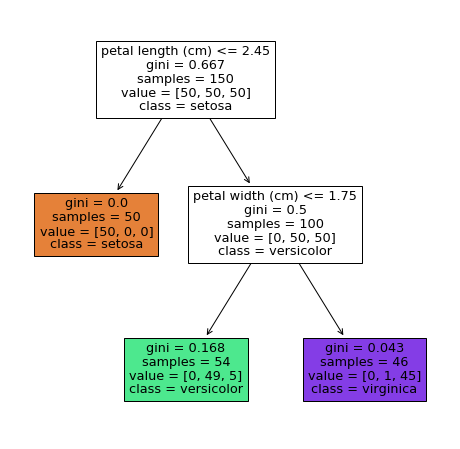

In [865]:
plt.figure(figsize=(8,8))
plot_tree(clf, feature_names=iris.feature_names, 
          class_names=iris.target_names,
         filled=True);

- **seuil** : On peut lire le nom de la variable discriminante et sa valeur (pour notre cas, il s'agit de la longueur de la pétale qui est inférieur à 2,35 cm). 
- **gini** : le coefficient de GINI du noeud parent
- **samples** : fait référence à la taille de l'échantillon
- **value** : fait référence à la taille de l'échantilllon pour chacune des classes.
- **class** : fait référence à la classe majoritaire lors de cette embranchement.

## Référence 

[TowardsDataScience, Decision Tree from scratch in python](https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775)